### **RoBERT RNN classifier on top of the Fine Tuned Bert Model**

In [ ]:
!pip install transformers==2.10.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
sys.path.append("./drive/MyDrive/ML-Project/RoBERT")

%matplotlib inline
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW# get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
import time

from utils import *
from Custom_Dataset_Class import NewsGroupDataset
from Bert_Classification import Bert_Classification_Model
from RoBERT import RoBERT_Model_20NG

from BERT_Hierarchical import BERT_Hierarchical_Model
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
TRAIN_BATCH_SIZE=1
EPOCH=5
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=NewsGroupDataset(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device=torch.device("cuda")
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=torch.load("./drive/MyDrive/ML-Project/RoBERT/20_newsgroup/model1/model_epoch4.pt")

model_rnn=RoBERT_Model_20NG(bertFineTuned=list(model.children())[0]).to(device)
optimizer=AdamW(model_rnn.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\nEpoch {epoch+1}/{EPOCH}\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_rnn, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"Average loss : {epoch_loss:.2f} - {(time.time()-t0)//60}min ({time.time()-t0:.2f}sec\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_rnn, device)
    print(f"Average Validation loss: {np.mean(val_losses_tmp):.2f} - {time.time()-t1:.2f}sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("The RoBERT model has been saved in drive")
    torch.save(model_rnn, f"./drive/MyDrive/ML-Project/RoBERT/20_newsgroup/RoBERT/RoBERT_rnn_epoch{epoch+1}.pt")

Loading BERT tokenizer...



Data Cleaning

Epoch 1/5

0/2201 (0.00%) - 0.65sec - loss = 2.8632
250/2201 (11.36%) - 49.80sec - loss = 1.8336
500/2201 (22.72%) - 44.73sec - loss = 1.3324
750/2201 (34.08%) - 42.63sec - loss = 0.7483
1000/2201 (45.43%) - 46.43sec - loss = 0.8217
1250/2201 (56.79%) - 42.64sec - loss = 0.4387
1500/2201 (68.15%) - 44.71sec - loss = 0.4346
1750/2201 (79.51%) - 50.27sec - loss = 0.2627
2000/2201 (90.87%) - 41.95sec - loss = 0.6637
Average loss : 0.99 - 6.0min (395.89sec

Average Validation loss: 0.52 - 69.54sec

{'accuracy': 0.8895131086142322, 'nb exemple': 534, 'true_prediction': 475, 'false_prediction': 59}
The RoBERT model has been saved in drive

Epoch 2/5

0/2201 (0.00%) - 0.11sec - loss = 1.7208
250/2201 (11.36%) - 46.93sec - loss = 0.3734
500/2201 (22.72%) - 41.78sec - loss = 0.1256
750/2201 (34.08%) - 47.12sec - loss = 0.4993
1000/2201 (45.43%) - 53.16sec - loss = 0.1280
1250/2201 (56.79%) - 44.36sec - loss = 0.2105
1500/2201 (68.15%) - 41.28sec - loss = 0.1539
1750/2201 (79.51%

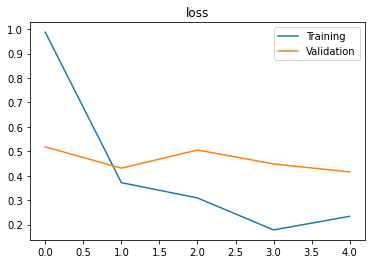

In [ ]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

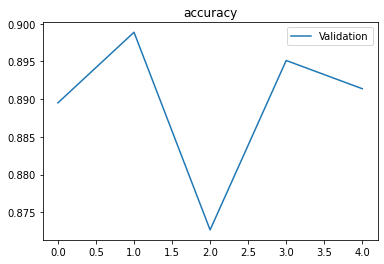

In [ ]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")